In [1]:
import shap
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import lightgbm
from sklearn.preprocessing import StandardScaler
from PyALE import ale

import warnings

In [58]:
with open(f'../output/predictions/outer_cv_accumulated_preds_test8_10outer.pkl', 'rb') as fr:
    cv_preds = pickle.load(fr)
    
from sklearn.metrics import average_precision_score

for j, (algo_name, outer_cv_data) in enumerate(cv_preds.items()):
    print("Algorithm: ", algo_name)
    pr_aucs = []

    gts = outer_cv_data['gt']
    probas = outer_cv_data['probas']

    for split_idx, (split_gts, split_probas) in enumerate(zip(gts, probas)):
        pr_auc = average_precision_score(split_gts, split_probas[:, 1])
        pr_aucs.append(pr_auc)
    
    lower, med, upper = np.percentile(pr_aucs, [2.5, 50, 97.5])
    print("{:.3f} [{:.3f}-{:.3f}]".format(med, lower, upper))

Algorithm:  RF
0.746 [0.455-0.982]
Algorithm:  LGBM
0.775 [0.486-1.000]
Algorithm:  SVC
0.759 [0.454-0.982]
Algorithm:  LR
0.720 [0.435-0.992]
Algorithm:  KNN
0.750 [0.445-0.992]


In [2]:
#model_name = 'LGBM_tuned_merged_10outer_100_backup.pkl'
model_name = 'LGBM_final.pkl'

with open(f'../output/fitted_models/{model_name}', 'rb') as fr:
    model = pickle.load(fr)

In [3]:
model_name = 'LGBM_tuned_merged_10outer_100_noscaling.pkl'

with open(f'../output/fitted_models/{model_name}', 'rb') as fr:
    model_ns = pickle.load(fr)

In [4]:
np.random.seed(1303)

In [5]:
# without scaling
train_ns = pd.read_csv("../input/train.csv")
test_ns = pd.read_csv("../input/external.csv")

# with scaling (model was fitted on this data)
train = train_ns.copy()
test = test_ns.copy()

scaler = StandardScaler()
numeric_cols = train_ns.select_dtypes(include=np.float64).columns.tolist()
train[numeric_cols] = scaler.fit_transform(train_ns[numeric_cols])
test[numeric_cols] = scaler.transform(test_ns[numeric_cols])

In [6]:
X_train, y_train = train.drop('symptoms', axis=1), train['symptoms']
X_test, y_test = test.drop('symptoms', axis=1), test['symptoms']


train_ns_raw = train_ns.copy()
test_ns_raw = test_ns.copy()
X_train_ns_raw, y_train_ns_raw = train_ns_raw.drop('symptoms', axis=1), train_ns_raw['symptoms']
X_test_ns_raw, y_test_ns_raw = test_ns_raw.drop('symptoms', axis=1), test_ns_raw['symptoms']

In [7]:
train_ns['gender'] = train_ns['gender'].map({0: 'Female', 1: 'Male'})
test_ns['gender'] = test_ns['gender'].map({0: 'Female', 1: 'Male'})

In [8]:
for c in ['hypertension', 'CAD', 'smoker', 'diabetes', 'lipids', 'stenosis', 'iph', 'symptoms']:
    train_ns[c] = train_ns[c].map({0: 'No', 1: 'Yes'})
    test_ns[c] = test_ns[c].map({0: 'No', 1: 'Yes'})    

In [9]:
# set types of binary/categorical variables to category
train_ns = train_ns.astype({
    "hypertension": 'category',
    "CAD": 'category',
    "smoker": 'category',
    "diabetes": 'category',
    "lipids": 'category',
    "stenosis": 'category',
    "iph": 'category',
    "gender": "category"
})
test_ns = test_ns.astype({
    "hypertension": 'category',
    "CAD": 'category',
    "smoker": 'category',
    "diabetes": 'category',
    "lipids": 'category',
    "stenosis": 'category',
    "iph": 'category',
    "gender": "category"    
})

In [10]:
#X_train, y_train = train.drop('symptoms', axis=1), train['symptoms']
#X_test, y_test = test.drop('symptoms', axis=1), test['symptoms']

X_train_ns, y_train_ns = train_ns.drop('symptoms', axis=1), train_ns['symptoms']
X_test_ns, y_test_ns = test_ns.drop('symptoms', axis=1), test_ns['symptoms']

In [11]:
columns_map = {
    "plaque_volume": "Plaque volume",
    "iph_volume": "IPH volume",
    "lipid_minus_iph": "(Lipid - IPH) volume",
    "lipid_volume": "Lipid volume",
    "mixed_volume": "Mixed volume",
    "calcium_volume": "Calcium volume",
    "perc_lipid": "% Lipid volume",
    "perc_mixed": "% Mixed volume",
    "perc_calcium": "% Calcium volume",
    "perc_iph": "% IPH volume",
    "perc_lipid_minus_iph": "% (Lipid - IPH) volume",
    "iph_total_lipid_ratio": "IPH/lipid volume ratio",
    "hypertension": "Hypertension",
    "cad": "CAD",
    "smoker": "Is Smoker",
    "age": "Age (Years)",
    "gender": "Gender",
    "diabetes": "Diabetes",
    "lipids": "Hyperlipidemia",
    "stenosis": "Stenosis",
    "iph": "Intraplaque Hemorrhage",
    "symptpoms": "Cerebrovascular Events"
}

In [12]:
inv_columns_map = {v: k for k, v in columns_map.items()}

In [13]:
X_test_ns = X_test_ns.rename(columns=columns_map)
X_test_ns_raw = X_test_ns_raw.rename(columns=columns_map)

In [14]:
X_train_ns = X_train_ns.rename(columns=columns_map)
X_train_ns_raw = X_train_ns_raw.rename(columns=columns_map)

# Do not execute

In [75]:
X_train_ns = X_train_ns.rename(columns=inv_columns_map)
#X_train_ns_raw = X_train_ns_raw.rename(columns=columns_map)

In [531]:
# train and test together
X, y = pd.concat([X_train, X_test], axis=0), pd.concat([y_train, y_test], axis=0)
X_ns, y_ns = pd.concat([X_train_ns, X_test_ns], axis=0), pd.concat([y_train_ns, y_test_ns], axis=0)
X_ns_raw, y_ns_raw = pd.concat([X_train_ns_raw, X_test_ns_raw], axis=0), pd.concat([y_train_ns_raw, y_test_ns_raw], axis=0)

# Start SHAPing

In [15]:
np.random.seed(1303)
exp = shap.Explainer(model, X_test) # create the explainer using the same data used for fitting
sh = exp(X_test_ns_raw) # explain unscaled train data without fancy / readable column values
sh.display_data = X_test_ns.values # associate data for display purposes (readable column names and values)

expected_value = exp.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]

In [16]:
from matplotlib.cm import register_cmap, get_cmap
import matplotlib.colors as clr
blue = "#4974a5"
lightblue = "#b0c4de"
salmon = "#ff8c69"
lightsalmon = "#FFD1C2"
darksalmon = "#e57e5e"

custom_cmap = clr.LinearSegmentedColormap.from_list('custom cmap', [lightblue, salmon], N=256)

## Summary plots: Beeswarm and bar plots

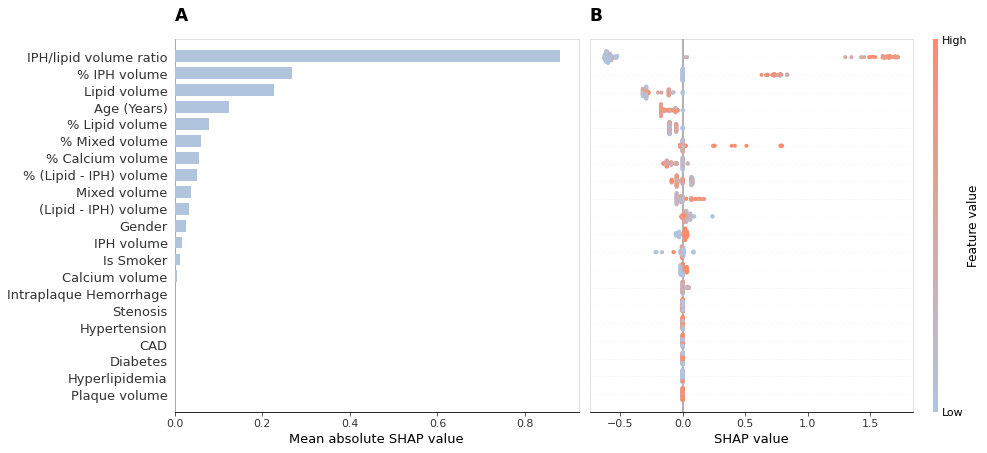

In [18]:
np.random.seed(1303)
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
shap.summary_plot(sh, 
                  plot_type='bar', 
                  show=False, 
                  color="lightsteelblue",
                  max_display=25,
                  plot_size=None)
ax1.set_xlabel("Mean absolute SHAP value")
ax1.patch.set_edgecolor('lightgray')  
ax1.patch.set_linewidth('0.7')  


ax2 = fig.add_subplot(122)

shap.summary_plot(sh, show=False, plot_size=None, cmap=custom_cmap)
ax2.set_xlabel("SHAP value")
#plt.gca().get_yaxis().set_ticks([])
ax2.set_yticks([])
ax2.patch.set_edgecolor('lightgray')  
ax2.patch.set_linewidth('0.7')

plt.tight_layout()


ax1.text(0, 1.05, "A", transform=ax1.transAxes, size=17, weight='bold')
ax2.text(0, 1.05, "B", transform=ax2.transAxes, size=17, weight='bold')

#print(matplotlib.rcParams['font.family'])
#plt.suptitle("Absolute and value-specific variable importance in the ML prediction", x=0.5, y=1.15, fontsize=20, weight="normal")


#plt.savefig("../output/plots/SHAP.pdf", dpi=400, bbox_inches='tight')
plt.show()

# Dependence plots

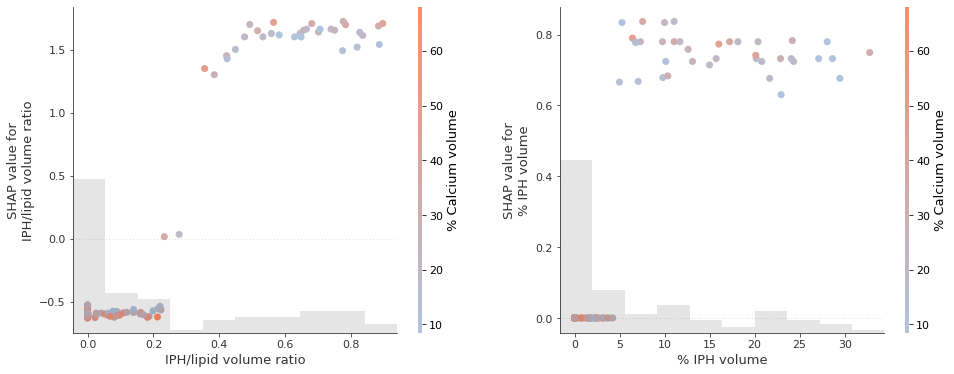

In [35]:
np.random.seed(1303)
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
#shap.plots.scatter(sh[:, "IPH to lipid volume ratio"],
#                  color=sh[:, "Lipid volume"],
#                  ax=ax[0], show=False,
#                  cmap=custom_cmap,
#                  dot_size=20,
#                  x_jitter=0.2)
shap.plots.scatter(sh[:, sh.abs.mean(0).argsort[-1]],
                  color=sh[:, "% Calcium volume"],
                  ax=ax[0], show=False,
                  cmap=custom_cmap,
                  dot_size=50,
                  x_jitter=0.1)
shap.plots.scatter(sh[:, sh.abs.mean(0).argsort[-2]],
                  color=sh[:, "% Calcium volume"],
                  ax=ax[1], show=False,
                  cmap=custom_cmap,
                  dot_size=50,
                  x_jitter=0.1)
#labels = ax.get_xticklabels()
#labels = [''] + list(calc_map.values()) + ['']
#ax.set_xticklabels(labels)
#plt.xticks(rotation=90)
#plt.savefig("../output/plots/dependency_calcifLR_stenosis.pdf", dpi=400, bbox_inches='tight')
plt.show()

# Accumulated Local Effects

# PyMint

In [17]:
import pymint

In [16]:
train_ns = pd.read_csv("../input/train.csv")
X_train_ns, y_train_ns = train_ns.drop('symptoms', axis=1), train_ns['symptoms']

In [20]:
estimators = [("LGBM", model_ns)]

In [21]:
explainer = pymint.InterpretToolkit(estimators, 
                                    X=X_train_ns, 
                                    y=y_train_ns)

## Accumulated Local Effects

In [22]:
ale_1d_ds = explainer.ale(features='all',
                          n_bootstrap=1000, 
                          n_jobs=8, 
                          n_bins=6)

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

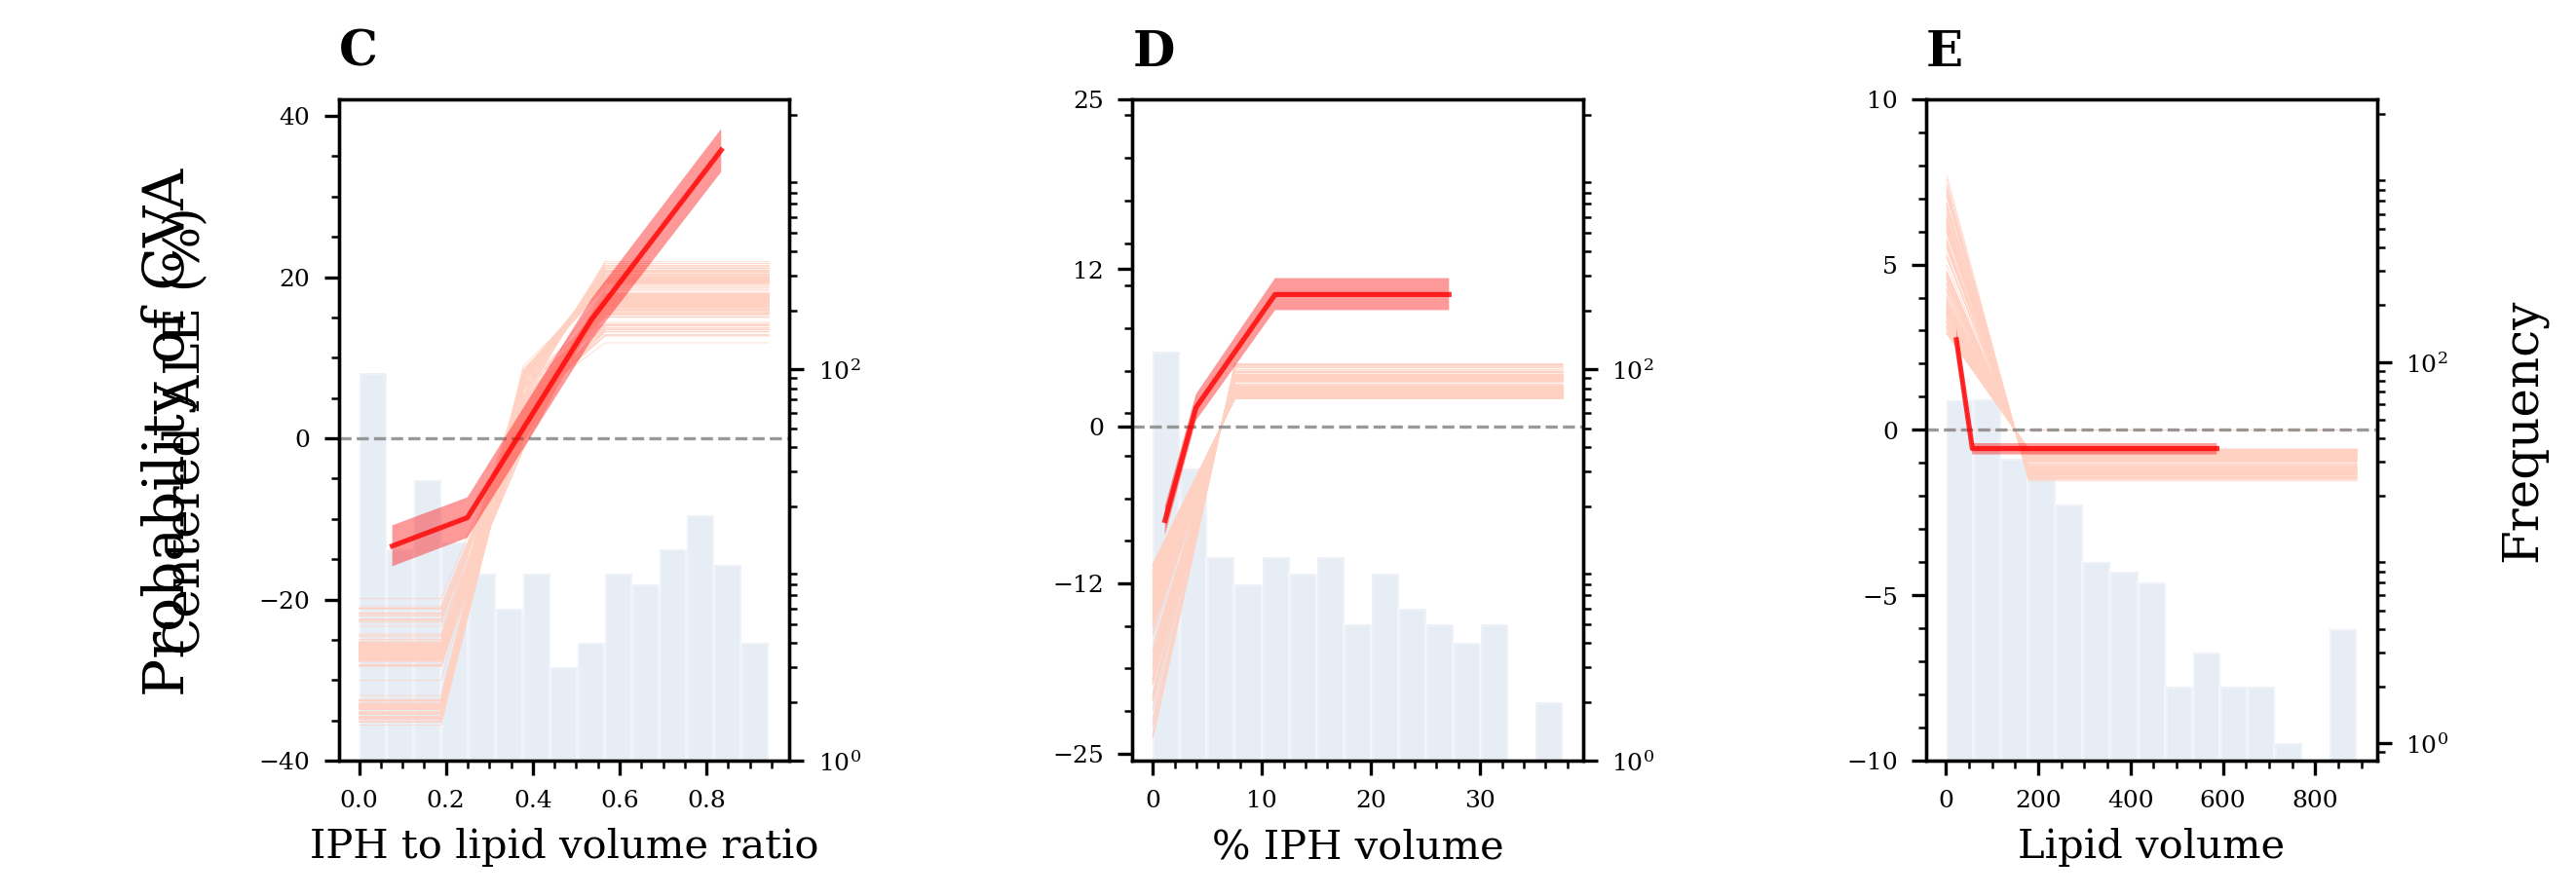

In [24]:
n = 3
top_n_idxs = np.flip(sh.abs.mean(0).argsort[-n:].values)
top_n_feats = X_train_ns.columns[top_n_idxs]

ice_ds = explainer.ice( features=top_n_feats, n_jobs=4, n_bins=6)

f, axes = explainer.plot_ale(ale = ale_1d_ds, 
                             features=top_n_feats,
                             display_feature_names=columns_map,
                             figsize=(9, 3),
                             ice_curves=ice_ds,
                             #fontsize=16,
                             #color_by=["perc_iph", "perc_iph", "perc_lipid"],
                             to_probability=True,
                             cmap=custom_cmap,
                             hist_color = lightblue)
axes[0].set_xlabel('IPH to lipid volume ratio', fontsize=10)
axes[1].set_xlabel('% IPH volume', fontsize=10)
axes[2].set_xlabel('Lipid volume', fontsize=10)


#f.suptitle("Effect on prediction of relevant features", x=0.5, y=1.05, fontsize=15, weight="normal")

rect3 = matplotlib.patches.Rectangle((20, 40),
                                     17, 200,
                                     color ='white')
f.patches.extend([rect3])
#axes[0].set_xlim(-3,3)
#axes[0].set_ylim(-3,3)

f.supylabel('Probability of CVA', x = 0.05)

for ax in axes:
    for i, line in enumerate(ax.get_lines()):
        lab = line.get_label()
        
        if lab == "LGBM":
            line.set_color("red")
        else:
            line.set_color(lightsalmon)
            line.set_zorder(-200)  # put the legend on top

    ax.get_lines()[-1].set_color("gray")
    
    for child in ax.get_children():
        if isinstance(child, matplotlib.text.Text):
            if child.get_text() in ["(a)", "(b)", "(c)"]:
                child.set_text("")

axes[0].text(0, 1.05, "C", transform=axes[0].transAxes, size=12, weight='bold')
axes[1].text(0, 1.05, "D", transform=axes[1].transAxes, size=12, weight='bold')
axes[2].text(0, 1.05, "E", transform=axes[2].transAxes, size=12, weight='bold')

f.savefig("../output/plots/ALE.pdf", dpi=400, bbox_inches='tight')

# Decision plots
Focusing on misclassifications

In [25]:
# load predicted probabilities of positive class
#probas = pd.read_csv("../output/predictions/external_test_preds_LGBM_tuned_merged_10outer_100.csv")
probas = pd.read_csv("../output/predictions/external_test_preds_LGBM_final.csv")

In [26]:
pos_class_proba = probas["proba"]

In [27]:
#threshold = 0.5
threshold = 0.5729885
labels = np.where(pos_class_proba >= threshold, 1, 0)
#fn_mask = (pos_class_proba < threshold) & (y_test_ns_raw == 1)
#fp_mask = (pos_class_proba >= threshold) & (y_test_ns_raw == 0)
#tp_mask = (pos_class_proba >= threshold) & (y_test_ns_raw == 1)
#tn_mask = (pos_class_proba < threshold) & (y_test_ns_raw == 0)
fn_mask = (labels == 0) & (y_test_ns_raw == 1)
fp_mask = (labels == 1) & (y_test_ns_raw == 0)
tp_mask = (labels == 1) & (y_test_ns_raw == 1)
tn_mask = (labels == 0) & (y_test_ns_raw == 0)

In [28]:
# index of false negatives
print("Indices of false negatives: ", list(fn_mask[fn_mask == True].index))
print("Indices of false positives: ", list(fn_mask[fp_mask == True].index))

Indices of false negatives:  [15, 17, 27, 80, 81, 98]
Indices of false positives:  [35, 49, 76, 79]


In [29]:
# Visualize predicted probabilities of false negatives along with index
print("False negatives")
[f"{idx}: {proba}" for idx, proba in zip(fn_mask[fn_mask == True].index, pos_class_proba[fn_mask])]

False negatives


['15: 0.1671830044392726',
 '17: 0.1671830044392726',
 '27: 0.177449504199039',
 '80: 0.154048683295726',
 '81: 0.1671830044392726',
 '98: 0.154048683295726']

In [30]:
# Visualize predicted probabilities of false negatives along with index
print("False positives")
[f"{idx}: {proba}" for idx, proba in zip(fp_mask[fp_mask == True].index, pos_class_proba[fp_mask])]

False positives


['35: 0.6126437292979644',
 '49: 0.6126437292979644',
 '76: 0.6126437292979644',
 '79: 0.6126437292979644']

In [31]:
#fn_idx = 17
#fp_idx = 79
fn_idx = 80
fp_idx = 49

In [32]:
# Visualize features of a false negative
print(X_test_ns_raw.iloc[fn_idx])
print("Symptoms: ", y_test_ns_raw[fn_idx])

Plaque volume             885.000000
IPH volume                 23.000000
(Lipid - IPH) volume      100.000000
Lipid volume              123.000000
Mixed volume              553.000000
Calcium volume            209.000000
% Lipid volume             13.898305
% Mixed volume             62.485876
% Calcium volume           23.615819
% IPH volume                2.598870
% (Lipid - IPH) volume     11.299435
IPH/lipid volume ratio      0.186992
Hypertension                1.000000
CAD                         0.000000
Is Smoker                   0.000000
Age (Years)                83.000000
Gender                      0.000000
Diabetes                    0.000000
Hyperlipidemia              1.000000
Stenosis                    1.000000
Intraplaque Hemorrhage      1.000000
Name: 80, dtype: float64
Symptoms:  1


In [33]:
# Visualize features of a false negative
print(X_test_ns_raw.iloc[fp_idx])
print("Symptoms: ", y_test_ns_raw[fp_idx])

Plaque volume             1201.000000
IPH volume                 289.000000
(Lipid - IPH) volume       254.000000
Lipid volume               543.000000
Mixed volume               433.000000
Calcium volume             225.000000
% Lipid volume              45.212323
% Mixed volume              36.053289
% Calcium volume            18.734388
% IPH volume                24.063281
% (Lipid - IPH) volume      21.149042
IPH/lipid volume ratio       0.532228
Hypertension                 1.000000
CAD                          1.000000
Is Smoker                    1.000000
Age (Years)                 83.000000
Gender                       1.000000
Diabetes                     0.000000
Hyperlipidemia               1.000000
Stenosis                     1.000000
Intraplaque Hemorrhage       1.000000
Name: 49, dtype: float64
Symptoms:  0


In [34]:
[f"{idx}: {col}" for idx, col in enumerate(X_test_ns_raw.columns)]
# 1, 0, 11, 9, 7, 10, 5, 8, 4, 3, 6, 2

['0: Plaque volume',
 '1: IPH volume',
 '2: (Lipid - IPH) volume',
 '3: Lipid volume',
 '4: Mixed volume',
 '5: Calcium volume',
 '6: % Lipid volume',
 '7: % Mixed volume',
 '8: % Calcium volume',
 '9: % IPH volume',
 '10: % (Lipid - IPH) volume',
 '11: IPH/lipid volume ratio',
 '12: Hypertension',
 '13: CAD',
 '14: Is Smoker',
 '15: Age (Years)',
 '16: Gender',
 '17: Diabetes',
 '18: Hyperlipidemia',
 '19: Stenosis',
 '20: Intraplaque Hemorrhage']

In [35]:
feat_idx_sorted = np.flip(sh.abs.mean(0).argsort.values)
col_names_sorted = X_train_ns.rename(columns=columns_map).columns[feat_idx_sorted]

In [36]:
def is_number(n):
    try:
        float(n)   # Type-casting the string to `float`.
                   # If string is not a valid `float`, 
                   # it'll raise `ValueError` exception
    except ValueError:
        return False
    return True

## Old and wrong

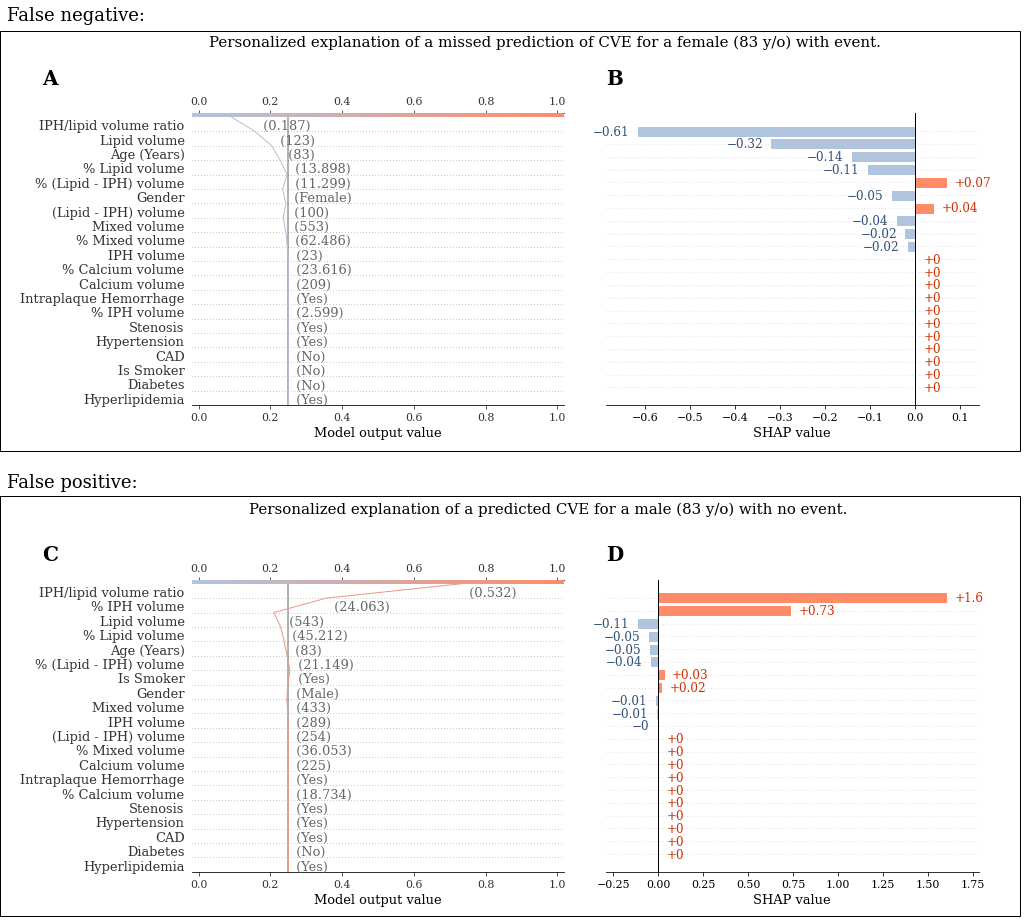

In [528]:
feature_order = list(reversed(feat_idx_sorted))


fig = plt.figure(figsize=(14,500))

### First figure start ###
fig.text(0, 1.04, "False negative:", size=18, weight='normal')    
fig.text(s="Personalized explanation of a missed prediction of CVE for a female (83 y/o) with event.",
            x=0.35, y=1.01, fontsize=15)

fst_ax1 = fig.add_subplot(221)
shap.decision_plot(expected_value, 
                   sh.values[fn_idx], 
                   X_test_ns.iloc[fn_idx],
                   feature_names=list(X_test_ns_raw.columns),
                   link='logit',
                   plot_color=custom_cmap,
                   show=False, auto_size_plot=False) 
fst_ax1.text(-0.4, 1.1, "A", transform=fst_ax1.transAxes, 
    size=20, weight='bold')


# add waterfall
fst_ax2 = fig.add_subplot(222)
shap.plots.bar(sh[fn_idx], show=False, 
               max_display=len(feature_order)
               # - 4
              )
fst_ax2.tick_params(axis='y', which='major', pad=25)
fst_ax2.set_yticks([])
fst_ax2.text(0, 1.1, "B", transform=fst_ax2.transAxes, size=20, weight='bold')

fst_annotations = [child for child in fst_ax2.get_children() if isinstance(child, matplotlib.text.Text)]


for i, annot in enumerate(fst_annotations):
    if is_number(annot.get_text().replace("+", "").replace("−","")): #special character -
        if "+" in annot.get_text():          
            fst_ax2.patches[i].set_color("#ff8c69")  
            annot.set_color("#d03000")
        else:
            fst_ax2.patches[i].set_color("#b0c4de")
            annot.set_color("#315076")

# add rectangle
rect = plt.Rectangle((0, 470), 1020, 420, linewidth=1, edgecolor='black', facecolor='none')
fig.patches.extend([rect])

### First figure end ###

# -------------------------------------------------------------

### Second figure start ###
fig.text(0, 0.5, "False positive:", size=18, weight='normal')  
fig.text(s="Personalized explanation of a predicted CVE for a male (83 y/o) with no event.",
            x=0.42, y=0.47, fontsize=15)

snd_ax1 = fig.add_subplot(223)
shap.decision_plot(expected_value, 
                   sh.values[fp_idx], 
                   X_test_ns.iloc[fp_idx],
                   feature_names=list(X_test_ns_raw.columns),
                   link='logit',
                   plot_color=custom_cmap,
                   show=False, auto_size_plot=False) 
snd_ax1.text(-0.4, 1.07, "C", transform=snd_ax1.transAxes, 
    size=20, weight='bold')


# add waterfall
snd_ax2 = fig.add_subplot(224)
shap.plots.bar(sh[fp_idx], show=False, 
               max_display=len(feature_order)
              )
snd_ax2.tick_params(axis='y', which='major', pad=25)
#plt.ylabel("...", labelpad=2)
snd_ax2.set_yticks([])
snd_ax2.text(0, 1.07, "D", transform=snd_ax2.transAxes, size=20, weight='bold')

snd_annotations = [child for child in snd_ax2.get_children() if isinstance(child, matplotlib.text.Text)] 

# first plot

for i, annot in enumerate(snd_annotations):
    if is_number(annot.get_text().replace("+", "").replace("−","")): #special character -
        if "+" in annot.get_text():          
            snd_ax2.patches[i].set_color("#ff8c69")  
            annot.set_color("#d03000")
        else:
            snd_ax2.patches[i].set_color("#b0c4de")
            annot.set_color("#315076")

# arrange subplots
plt.tight_layout(rect=[0.0, 0.0, 1.75, 1.0])
plt.subplots_adjust(hspace=0.6)

# add second rectangle
rect = plt.Rectangle((0, 5), 1020, 420, linewidth=1, edgecolor='black', facecolor='none')
fig.patches.extend([rect])

### Second figure end ###


# add general title to the plot
#fig.suptitle("Interpretation of individual predictions", x=0.9, y=1.10, fontsize=20, weight="normal")


plt.savefig("../output/plots/misclassifications_WRONG.pdf", dpi=400, bbox_inches='tight')
plt.show()

# start from the second subplot (bottom) and then the first plot

## New and correct

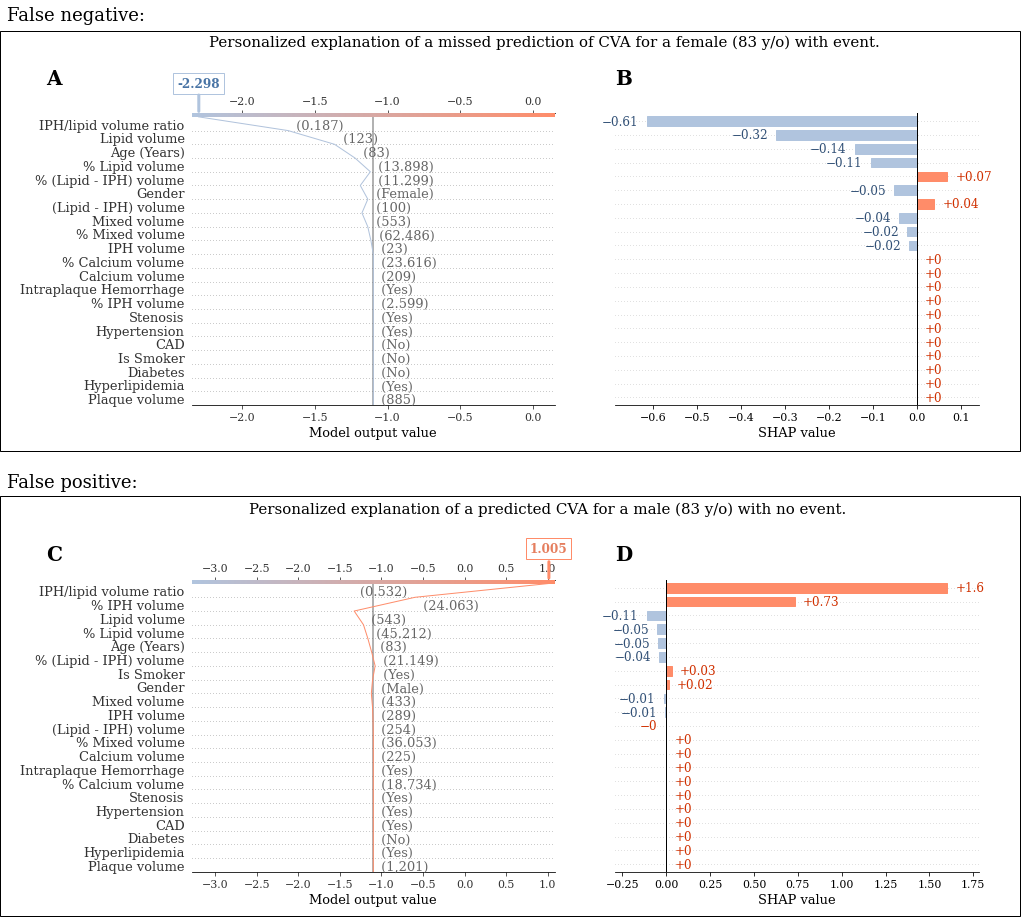

In [37]:
feature_order = list(reversed(feat_idx_sorted))


fig = plt.figure(figsize=(14, 600))

### First figure start ###
fig.text(0, 1.04, "False negative:", size=18, weight='normal')    
fig.text(s="Personalized explanation of a missed prediction of CVA for a female (83 y/o) with event.",
            x=0.35, y=1.01, fontsize=15)

fst_ax1 = fig.add_subplot(221)
shap.decision_plot(expected_value, 
                   sh.values[fn_idx], 
                   X_test_ns.iloc[fn_idx],
                   feature_names=list(X_test_ns_raw.columns),
                   link='identity',
                   plot_color=custom_cmap,
                   feature_display_range=slice(None, -len(feature_order)-1, -1),
                   show=False, auto_size_plot=False) 
fst_ax1.text(-0.4, 1.1, "A", transform=fst_ax1.transAxes, 
    size=20, weight='bold')

model_output_logodds = sh.base_values[0] + sh.values[fn_idx].sum()
fst_ax1.text(-0.04, 1.09, "{:.3f}".format(model_output_logodds), 
             transform=fst_ax1.transAxes, 
             size=12, 
             weight='bold',
             color=blue,
             bbox=dict(facecolor='none', edgecolor=lightblue))
fst_ax1.annotate("",
             xy=(0.02, 1.00), xycoords='axes fraction',
             xytext=(0.02, 1.07), textcoords='axes fraction',
             arrowprops=dict(arrowstyle="-",
                             lw=3,
                             color=lightblue,
                             connectionstyle="arc3,rad=0."))

# reduce fontsize of feature values
#annots = [child for child in fst_ax1.get_children() if isinstance(child, matplotlib.text.Text) and child.get_text() != '']
#for annot in annots:
#    annot.set_fontsize(9)

# add waterfall
fst_ax2 = fig.add_subplot(222)
shap.plots.bar(sh[fn_idx], show=False, 
               max_display=len(feature_order)
               # - 4
              )
fst_ax2.margins(y=0.01)
fst_ax2.tick_params(axis='y', which='major', pad=25)
fst_ax2.set_yticks([])
fst_ax2.text(0, 1.1, "B", transform=fst_ax2.transAxes, size=20, weight='bold')

fst_annotations = [child for child in fst_ax2.get_children() if isinstance(child, matplotlib.text.Text)]


for i, annot in enumerate(fst_annotations):
    t = annot.get_text().replace("+", "+").replace("−","-")
    if is_number(t): #special character -
        t = float(t)
        if t >= 0:          
            fst_ax2.patches[i].set_color("#ff8c69")  
            annot.set_color("#d03000")
        else:
            fst_ax2.patches[i].set_color("#b0c4de")
            annot.set_color("#315076")

# add rectangle
rect = plt.Rectangle((0, 470), 1020, 420, linewidth=1, edgecolor='black', facecolor='none')
fig.patches.extend([rect])

### First figure end ###

# -------------------------------------------------------------

### Second figure start ###
fig.text(0, 0.5, "False positive:", size=18, weight='normal')  
fig.text(s="Personalized explanation of a predicted CVA for a male (83 y/o) with no event.",
            x=0.42, y=0.47, fontsize=15)

snd_ax1 = fig.add_subplot(223)
shap.decision_plot(expected_value, 
                   sh.values[fp_idx], 
                   X_test_ns.iloc[fp_idx],
                   feature_names=list(X_test_ns_raw.columns),
                   link='identity',
                   plot_color=custom_cmap,
                   feature_display_range=slice(None, -len(feature_order)-1, -1),
                   show=False, auto_size_plot=False) 
snd_ax1.text(-0.4, 1.07, "C", transform=snd_ax1.transAxes, size=20, weight='bold')

model_output_logodds = sh.base_values[0] + sh.values[fp_idx].sum()
snd_ax1.text(0.93, 1.095, "{:.3f}".format(model_output_logodds), 
             transform=snd_ax1.transAxes, 
             size=12, 
             weight='bold',
             color=darksalmon,
             bbox=dict(facecolor='none', edgecolor=salmon))
snd_ax1.annotate("",
             xy=(0.983, 1.00), xycoords='axes fraction',
             xytext=(0.983, 1.07), textcoords='axes fraction',
             arrowprops=dict(arrowstyle="-",
                             lw=3,
                             color=salmon,
                             connectionstyle="arc3,rad=0."))


# add waterfall
snd_ax2 = fig.add_subplot(224)
shap.plots.bar(sh[fp_idx], show=False, 
               max_display=len(feature_order)
              )
snd_ax2.tick_params(axis='y', which='major', pad=25)
#plt.ylabel("...", labelpad=2)
snd_ax2.set_yticks([])
snd_ax2.margins(y=0.01)
snd_ax2.text(0, 1.07, "D", transform=snd_ax2.transAxes, size=20, weight='bold')


snd_annotations = [child for child in snd_ax2.get_children() if isinstance(child, matplotlib.text.Text)] 

### Second plot

for i, annot in enumerate(snd_annotations):
    t = annot.get_text().replace("+", "+").replace("−","-")
    if is_number(t): #special character -
        t = float(t)
        if t >= 0:          
            snd_ax2.patches[i].set_color("#ff8c69")  
            annot.set_color("#d03000")
        else:
            snd_ax2.patches[i].set_color("#b0c4de")
            annot.set_color("#315076")

# arrange subplots
#plt.tight_layout(rect=[0.0, 0.0, 1.75, 1.0])
plt.tight_layout(rect=[0.0, 0.0, 1.75, 1.0])
plt.subplots_adjust(hspace=0.6)

# add second rectangle
rect = plt.Rectangle((0, 5), 1020, 420, linewidth=1, edgecolor='black', facecolor='none')
fig.patches.extend([rect])

### Second figure end ###


# add general title to the plot
#fig.suptitle("Interpretation of individual predictions", x=0.9, y=1.10, fontsize=20, weight="normal")


plt.savefig("../output/plots/misclassifications_logodds.pdf", dpi=400, bbox_inches='tight')
plt.show()

# start from the second subplot (bottom) and then the first plot

# Misc

In [314]:
exp2 = shap.explainers.Tree(model, X_test, 
                            feature_dependence="independent",
                            model_output="probability") # create the explainer using the same data used for fitting
sh2 = exp2(X_test) # explain unscaled train data without fancy / readable column values
sh2.display_data = X_test_ns.values # associate data for display purposes (readable column names and values)
    
ev2 = exp2.expected_value
if isinstance(ev2, list):
    ev2 = ev2[1]

ev2, sh2.values[fp_idx].sum(), ev2 + sh2.values[fp_idx].sum(), pos_class_proba[fp_idx], ev2 + sh2.values[fp_idx].sum() == pos_class_proba[fp_idx]

(0.2776862741421754,
 0.3349574550768571,
 0.6126437292190325,
 0.6126437292979644,
 False)

In [534]:
np.random.seed(1303)
exp2 = shap.TreeExplainer(model) # create the explainer using the same data used for fitting
sh2 = exp2.shap_values(X) # explain unscaled train data without fancy / readable column values
sh3 = exp2(X)
#sh2.display_data = X_test_ns.values # associate data for display purposes (readable column names and values)

In [535]:
sh3.values[49][:, 1]

array([ 0.        ,  0.03990711, -0.00581389,  0.18000857,  0.01576723,
       -0.00746001,  0.07283761, -0.25797989,  0.02860046, -0.25161271,
       -0.03796434, -0.7796186 ,  0.        ,  0.        ,  0.01167002,
        0.12065821, -0.05405178,  0.        ,  0.        ,  0.        ,
        0.        ])

In [532]:
np.random.seed(1303)
exp2 = shap.explainers.Tree(model) # create the explainer using the same data used for fitting
sh2 = exp2.shap_values(X)

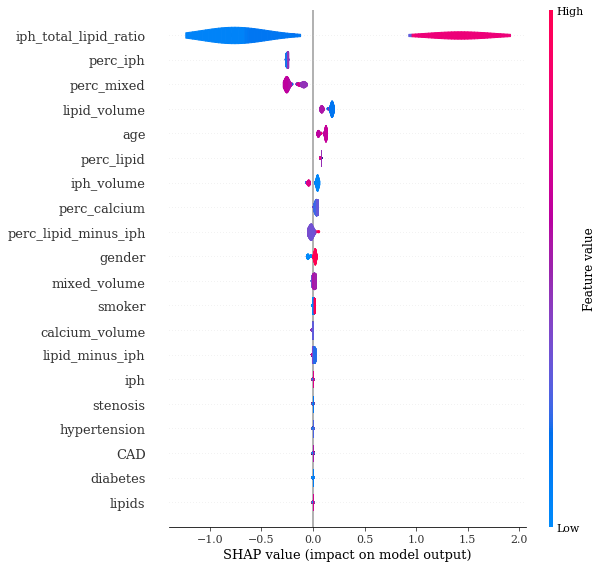

In [538]:
shap.summary_plot(sh2[1], X, plot_type="violin")

In [366]:
exp2 = shap.TreeExplainer(model) # create the explainer using the same data used for fitting
sh2 = exp2(X_test) # explain unscaled train data without fancy / readable column values
shaps2 = exp2.shap_values(X_test)
sh2.display_data = X_test_ns.values # associate data for display purposes (readable column names and values)
    
ev2 = exp2.expected_value
if isinstance(ev2, list):
    ev2 = ev2[1]

In [406]:
n = sh[fp_idx].values.shape[0]
bv = sh.base_values[0]

(sh[fp_idx].values + (bv/n)).sum()

1.0054751422945507

In [407]:
n = sh[fn_idx].values.shape[0]
bv = sh.base_values[0]

(sh[fn_idx].values + (bv/n)).sum()

-2.297732352862125

In [388]:
sh[fn_idx].values.sum() + sh[fn_idx].base_values, sh[fp_idx].values.sum() + sh[fp_idx].base_values

(-2.297732352862125, 1.0054751422945511)

# Explore feature importance on train data

In [544]:
np.random.seed(1303)
exp = shap.Explainer(model, shap.sample(X_train, 100)) # create the explainer using the same data used for fitting
sh = exp(X_train_ns_raw) # explain unscaled train data without fancy / readable column values
sh.display_data = X_train_ns.values # associate data for display purposes (readable column names and values)

ev = exp.expected_value
if isinstance(ev, list):
    ev = ev[1]

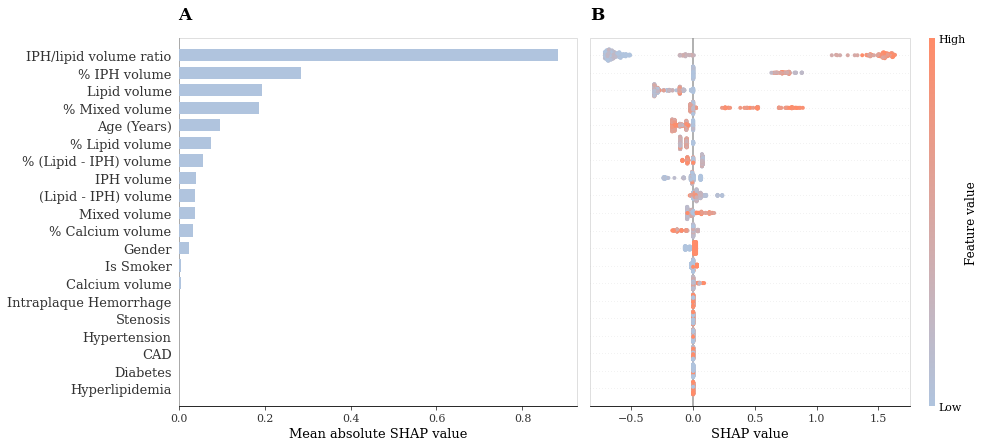

In [545]:
np.random.seed(1303)
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
shap.summary_plot(sh, 
                  plot_type='bar', 
                  show=False, 
                  color="lightsteelblue",
                  plot_size=None)
ax1.set_xlabel("Mean absolute SHAP value")
ax1.patch.set_edgecolor('lightgray')  
ax1.patch.set_linewidth('0.7')  


ax2 = fig.add_subplot(122)

shap.summary_plot(sh, show=False, plot_size=None, cmap=custom_cmap)
ax2.set_xlabel("SHAP value")
#plt.gca().get_yaxis().set_ticks([])
ax2.set_yticks([])
ax2.patch.set_edgecolor('lightgray')  
ax2.patch.set_linewidth('0.7')

plt.tight_layout()


ax1.text(0, 1.05, "A", transform=ax1.transAxes, size=17, weight='bold')
ax2.text(0, 1.05, "B", transform=ax2.transAxes, size=17, weight='bold')

#print(matplotlib.rcParams['font.family'])
#plt.suptitle("Absolute and value-specific variable importance in the ML prediction", x=0.5, y=1.15, fontsize=20, weight="normal")


plt.savefig("../output/plots/SHAP_train_data.pdf", dpi=400, bbox_inches='tight')
plt.show()

In [541]:
np.random.seed(1303)
exp = shap.Explainer(model, shap.sample(X, 100)) # create the explainer using the same data used for fitting
sh = exp(X_ns_raw) # explain unscaled train data without fancy / readable column values
sh.display_data = X_ns.values # associate data for display purposes (readable column names and values)

ev = exp.expected_value
if isinstance(ev, list):
    ev = ev[1]

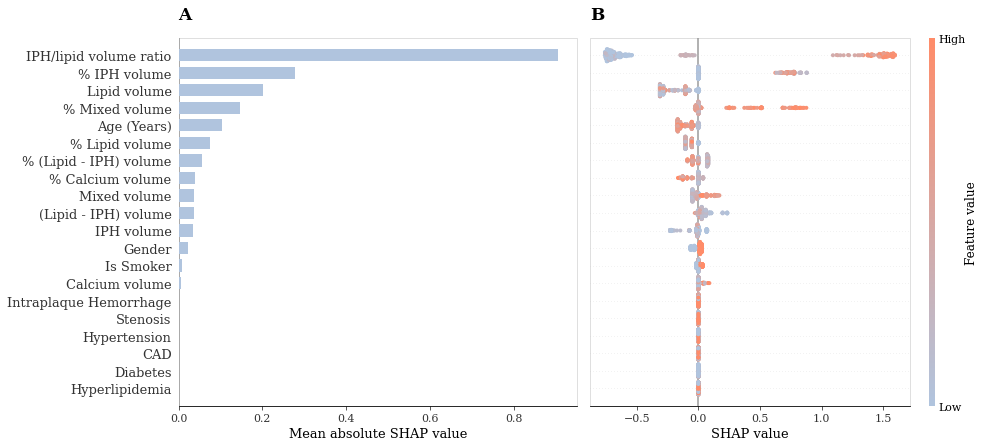

In [543]:
np.random.seed(1303)
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
shap.summary_plot(sh, 
                  plot_type='bar', 
                  show=False, 
                  color="lightsteelblue",
                  plot_size=None)
ax1.set_xlabel("Mean absolute SHAP value")
ax1.patch.set_edgecolor('lightgray')  
ax1.patch.set_linewidth('0.7')  


ax2 = fig.add_subplot(122)

shap.summary_plot(sh, show=False, plot_size=None, cmap=custom_cmap)
ax2.set_xlabel("SHAP value")
#plt.gca().get_yaxis().set_ticks([])
ax2.set_yticks([])
ax2.patch.set_edgecolor('lightgray')  
ax2.patch.set_linewidth('0.7')

plt.tight_layout()


ax1.text(0, 1.05, "A", transform=ax1.transAxes, size=17, weight='bold')
ax2.text(0, 1.05, "B", transform=ax2.transAxes, size=17, weight='bold')

#print(matplotlib.rcParams['font.family'])
#plt.suptitle("Absolute and value-specific variable importance in the ML prediction", x=0.5, y=1.15, fontsize=20, weight="normal")


plt.savefig("../output/plots/SHAP_all_data.pdf", dpi=400, bbox_inches='tight')
plt.show()